In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import hdbscan
import nltk
import spacy

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

spaci = spacy.load("en_core_web_sm")

In [46]:
df = pd.read_csv('hsbc_twitter_DATA_not GENERAL.csv')
df.rename(columns={"NEW HUMAN CATEGORY\n 0-1000 /4000-4468 Michael\n 1000-2500 Mehmet \n 2500-4000 Aryamaan":"labels"}, inplace = True)
df.head()

tweet  \
0   2  @LondOgrad Hello Eugene, we do apologise for t...   
1   8  @ncohen4 @CooperativeBank @HSBC @HSBCUKBusines...   
2   9  @sharaola Good morning, sorry for your experie...   
3  11        @Bounce_BackLoan Still not a peep from HSBC   
4  15  @djm2481 @mgcmitchell @HSBC_UK Thanks for the ...   

  HUMAN CATEGORY\n ARYAMAAN:1-1000,4000-4468\n Michael-Mehmet:1000-4000  \
0                            CUSTOMER_SERVICE_ISSUES                      
1                                     BAD REPUTATION                      
2                            CUSTOMER_SERVICE_ISSUES                      
3                                              DELAY                      
4                          Customer Service Response                      

                SUB CATEGORY                   COMMENTS  \
0                        NaN       bad customer service   
1                        NaN                        NaN   
2                        NaN       bad customer service   
3  Delay_in_bounce_back_loan  delay in bounce back loan   
4                        NaN     customer service reply   

                      labels             SUB CATEGORY.1  \
0  Customer Service Response                        NaN   
1                    General                        NaN   
2  Customer Service Response                        NaN   
3                      DELAY  Delay_in_bounce_back_loan   
4  Customer Service Response                        NaN   

                  COMMENTS.1 human category (Tarun)  SUB CATEGORY.2  \
0     customer service reply                    NaN             NaN   
1                        NaN                    NaN             NaN   
2     customer service reply                    NaN             NaN   
3  delay in bounce back loan                    NaN             NaN   
4     customer service reply                    NaN             NaN   

   COMMENTS.2             NEW CATEGORY              keyword  \
0         NaN  customer_service issues                delay   
1         NaN           Bad_reputation              unhappy   
2         NaN  customer_service issues      customerservice   
3         NaN    Delay_Bounceback_Loan  delay , no response   
4         NaN                  General          any queries   

                         human - category  \
0                                   Delay   
1               {'category': 'Reputation'   
2  {'category': 'customer_service issues'   
3         {'category': 'Bounce back loan'   
4               {'category': 'Reputation'   

                                human - Sub category  \
0                                     delay in calls   
1                     subcategory': 'Bad reputation'   
2                    subcategory': 'customerservice'   
3            subcategory': 'Bounce back loan delays'   
4  subcategory': 'General Response from Bank (tha...   

                                 Comment HUMAN CATGEORY_NEW(ARYA)  \
0                            Huge Queues  customer_service_issues   
1  worst experience from customer – mess           BAD_REPUTATION   
2             General response from bank                  General   
3                               No reply    DELAY_BOUNCEBACK_LOAN   
4             General response from bank                      NaN   

              location   COMMENTS (FROM PARIJAAT)  \
0           London, UK                        NaN   
1    Plymouth, England                        NaN   
2         Cairo, Egypt  General message from hsbc   
3  Enschede, Nederland                      DELAY   
4       United Kingdom                        NaN   

                          Category                               Sub-category  
0             {'category': 'Delay'  subcategory': 'Delay in bounce back loan'  
1        {'category': 'Reputation'            subcategory': 'Good reputation'  
2        {'category': 'Reputation'            subcategory': 'Good reputation'  
3  {'category': 'Bounce back loan'    subcategory': 'Bounce b

In [47]:
df.labels.value_counts().sum()

4462

In [48]:
# reducing General Data 1500
drop_indices = np.random.choice(df.loc[df["labels"]=="General"].index, 1500, replace=False)
df = df.drop(drop_indices)

In [49]:
df.labels.value_counts()

General                      769
DELAY                        716
Customer Service Response    653
BAD REPUTATION               229
CUSTOMER_SERVICE_ISSUES      227
Customer Query               168
GOOD REPUTATION              101
COVID19                       50
CHURN                         37
ESG                            6
Junk                           4
Language                       2
Name: labels, dtype: int64

In [50]:
df.tweet.str.contains("bye").sum()

3

In [51]:
# label = pd.DataFrame(df.groupby("labels", as_index=False)["tweet"].apply(lambda x: " ".join(x)))
# bad_repu = label[label.labels == "BAD REPUTATION"]["reviewText"].tolist()

In [52]:
import string
def remove_punc(txt):
    txt = "".join([c for c in txt if c not in string.punctuation])
    txt = txt.replace("\n", " ")
    return txt.lower()
df.tweet = df.tweet.apply(lambda x: remove_punc(x))

In [53]:
def word_root(text):
    list_data3=[]
    
    doc = spaci(text)
    for token in doc:
        lemma = token.lemma_
        list_data3.append(lemma)
    return " ".join(list_data3)
df.tweet = df.tweet.apply(lambda x: word_root(x))  

In [54]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in df.tweet])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(10)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [55]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in df.tweet])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(10)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [56]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [57]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [58]:
bigrams = [' '.join(x) for x in bigram_pmi.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in trigram_pmi.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [59]:
print(bigrams)

['thewvb rameezhaider13', 'asset growth', 'doubledigit wealth', '0121 614', 'wealth asset', 'sony hongkong', 'shannoncallag19 jono5757a', 'finger cross', 'sole trader', '0800 0121', 'contest contestalert', '03457 404', 'tccq2020 contest', 'fromthequizmaster tccq2020', '404 404', 'life 16', 'gold market', 'regret every', 'absolute joke', 'stay safe', '10 digit', 'safe claude', 'live chat', 'case handler', 'ðÿ˜ ©', 'alison httpstcoocvb5tjrbz', 'register mobile', 'contestalert tatacrucible', 'cut off', 'connect within', 'full name', 'information hence', 'digit complaint', 'hence request', 'every second', '16 year', 'concern refer', 'see doubledigit', 'lloydsbank starlingbank', '1 minute', '24 hour', 'within 1', 'post code', 'echo sign', 'debit card', '48 hour', 'good luck', 'kashif httpstcoocvb5tjrbz', 'direct message', 'concerned team', 'tatacrucible join', 'link below', 'credit card', 'internet banking', 'joke bad', 'reference number', 'write into', 'hello mr', 'at least', 'telephone ba

In [75]:
trigrams1 = [trig for trig in trigrams if all([word.isalpha() for word in trig.split()])]
trigrams2 = []
# for trigram1 in trigrams1.split:



for trigram in trigrams1:
    word = trigram.split(" ")
    if len(word[0]) > 3 and\
       len(word[1]) > 1 and\
       len(word[2]) > 3:
        trigrams2.append(word)

trigrams2
      
        
        
    

[['doubledigit', 'wealth', 'asset'],
 ['wealth', 'asset', 'growth'],
 ['regret', 'every', 'second'],
 ['stay', 'safe', 'claude'],
 ['contest', 'contestalert', 'tatacrucible'],
 ['contestalert', 'tatacrucible', 'join'],
 ['growth', 'in', 'asia'],
 ['information', 'hence', 'request'],
 ['register', 'mobile', 'number'],
 ['more', 'information', 'hence'],
 ['digit', 'complaint', 'number'],
 ['quickly', 'as', 'possible'],
 ['touch', 'with', 'youalpa'],
 ['every', 'second', 'call'],
 ['your', 'register', 'mobile'],
 ['fetch', 'your', 'detail'],
 ['appreciate', 'your', 'patience'],
 ['joke', 'bad', 'customer'],
 ['your', 'full', 'name'],
 ['more', 'than', 'happy'],
 ['below', 'thank', 'kashif'],
 ['your', 'concern', 'refer'],
 ['need', 'more', 'information'],
 ['kindly', 'write', 'into'],
 ['hsbcuk', 'lloydsbank', 'starlingbank'],
 ['bounce', 'back', 'loan'],
 ['name', 'and', 'postcode'],
 ['phone', 'banking', 'service'],
 ['would', 'need', 'more'],
 ['hsbc', 'see', 'doubledigit'],
 ['your', 

In [41]:
replace_word = {"covid":"covid", "corona":"covid","pandemi":"covid", 
                "bouncebackloan":"bounce back loan", "noresponse":"no_response", 
                "bounceback":"bounce back", "backloan":"back loan","on hold":"on_hold",
                "bbl":"bounce back loan", "any news":"any_news","give up":"give_up", 
                "gave up":"give_up", "well done":"well_done"}
for key, value in replace_word.items():
    df.tweet.replace(f"\S*{key}\S*" , f"{value}", regex=True, inplace = True)

In [42]:
"on_hold" in replace_word.values()

False

In [25]:
junk_words = "nt citi kashif a very were yet than through via here rishisunak more much getting go going ive dont able when which who year barclays hsbcin amp like an no any since after banking im there out how starlingbank starling one only again over other then am may some do cant about banks would could its even their after has them get got within now all just if what or at had hsbcukbusiness up by into will an was our us so been hsbcuk co om ke ha gone your we can from as but to the hsbc and of you for are have they is my hsbc_uk with it in on this ðÿ be not bank me that"
junk_words_list = junk_words.split(" ")

In [26]:
def remove_unicode(text):

    try:
        text = text.encode("latin_1").decode("raw_unicode_escape").encode('utf-16', 'surrogatepass').decode('utf-16')
    except:
        text = text

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", re.UNICODE)

    text = re.sub(emoji_pattern, '', text)
    text = ''.join(text.split('\\n')) # to remove uncompiled \n
    text = re.sub('\n', '', text)     # to remove compiled \n

    return text

In [27]:
def clean_data(text, small_word_lmt=0, extra_words=junk_words_list,replace_word=replace_word):
    list_data2=[]
    text = remove_unicode(text)
    sentence=text.split(' ')
    for word in sentence:
        if word == "hi":
            word = word.replace("hi", "hello")
        if word in replace_word.values():
            list_data2.append(word)
        elif not word.startswith('http') \
           and word.isalpha() \
           and word not in extra_words:
            list_data2.append(word)
    return " ".join(list_data2)
df.tweet = df.tweet.apply(lambda x: clean_data(x))

In [28]:
"lai".isalpha()

True

In [29]:
df.tweet.str.contains("worst").sum()

70

In [31]:
df.tweet.str.contains("bye").sum()

5

In [32]:
word_root("worst")

'worst'

In [33]:
# adjustment for non-english words

# nltk.download('words')
# eng_words = set(nltk.corpus.words.words())
# df["eng"] = df.tweet.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i in eng_words]))
# df["noneng"] = df.tweet.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i not in eng_words]))
# df.noneng.tolist()

In [43]:
replace_ngrams = {"bounce back loan":"bounce_back_loan", "name post code":"name_post_code","full name":"full_name",
                  "credit card":"credit_card","click link below":"click_link_below",
                  "worst customer experience":"worst_customer_experience",
                  "thank respond back":"thank_respond_back","phone service team":"phone_service_team",
                  "thank write back":"thank_write_back","feeder account":"feeder_account", "still wait":"still_wait",
                  "business account":"business_account","business customer":"business_customer","good morning":"good_morning",
                  "week ago":"week_ago","post code":"post_code","click link":"click_link","let know":"let_know",
                  "call back":"call_back","personal account":"personal_account","refer link":"refer_link","link below":"link_below",
                  "name post":"name_post","hear nothing":"hear_nothing","sorry hear":"sorry_hear", "hello thank":"hello_thank",
                  "loan application":"loan_application","loan apply":"loan_apply", "on_hold":"on_hold",
                  "any_news":"any_news","give_up":"give_up","give_up":"give_up", "well_done":"well_done",
                  "any_new":"any_new"}
for key, value in replace_ngrams.items():
    if value == "bounce_back_loan":
        df.tweet.replace(f"\S*{key}\S*" , f"{value}", regex=True, inplace = True)
    else:
        df.tweet.replace(f"\S*{key}\S*" , f"{value} "*3, regex=True, inplace = True)
    

In [44]:
df.tweet.str.contains("worst").sum()

70

In [45]:
# replace_key_words = ['delay', 'wait', 'on_hold', 'any_news', 'awful', 'disappointed', 'give_up', 'regret', 'worse', 'worst', 'unhappy', 'sucksunbelievable', 'frustrated', 'disgusted', 'happy', 'disgrace', 'awesome', 'fantastic', 'well_done', 'great', 'leave', 'bye', 'switch', 'covidenvironment', 'fossil', 'coal', 'fuel', 'climate', 'carbon', 'best', 'wonderfull']
# for key_word in replace_key_words:
#     df.tweet.replace(f"\S*{key_word}\S*" , f"{key_word} "*2, regex=True, inplace = True)


In [46]:
df.drop(df[df.tweet.str.contains("tatacrucible")].index, axis=0,inplace=True)

In [47]:
df_clean = df.tweet
df_clean.shape

(2910,)

In [48]:
df_clean = df_clean.dropna()
df_clean.shape

(2910,)

In [49]:
list_data = df_clean.to_list()
list_data = [str(sent) for sent in list_data]

In [50]:
from sentence_transformers import SentenceTransformer

In [51]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1

In [52]:
model=SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings1 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/91 [00:00<?, ?it/s]

In [53]:
# embeddings1[embeddings1.argmax()]

In [54]:
model=SentenceTransformer('paraphrase-distilroberta-base-v1')
embeddings2 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/91 [00:00<?, ?it/s]

In [55]:
embeddings1_norm = embeddings1 /  np.linalg.norm(embeddings1, axis=1, keepdims=True)
embeddings2_norm = embeddings2 /  np.linalg.norm(embeddings2, axis=1, keepdims=True)

In [56]:
import umap

In [57]:
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE

In [58]:
UMAP_bert1 = umap.UMAP(n_components=2).fit_transform(embeddings1)
UMAP_bert1_norm = umap.UMAP(n_components=2).fit_transform(embeddings1_norm)

UMAP_bert2 = umap.UMAP(n_components=2).fit_transform(embeddings2)
UMAP_bert2_norm = umap.UMAP(n_components=2).fit_transform(embeddings2_norm)

#n_neighbors=10, min_dist=0.0, 

In [59]:
PCA_bert1 = PCA(n_components=2).fit_transform(embeddings1)
PCA_bert1_norm = PCA(n_components=2).fit_transform(embeddings1_norm)

PCA_bert2 = PCA(n_components=2).fit_transform(embeddings2)
PCA_bert2_norm = PCA(n_components=2).fit_transform(embeddings2_norm)

In [60]:
tSNE_bert1 = TSNE(n_components=2).fit_transform(embeddings1)
tSNE_bert1_norm = TSNE(n_components=2).fit_transform(embeddings1_norm)

tSNE_bert2 = TSNE(n_components=2).fit_transform(embeddings2)
tSNE_bert2_norm = TSNE(n_components=2).fit_transform(embeddings2_norm)

In [61]:
from pyclustertend import hopkins
hopkins(UMAP_bert2,UMAP_bert2.shape[0])

0.09628644428507208

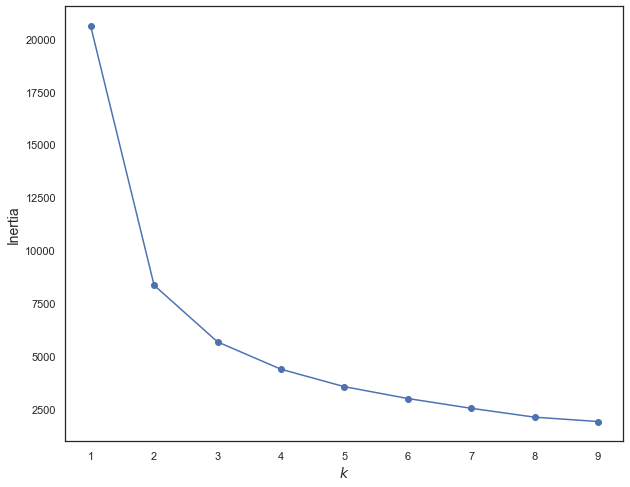

In [62]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(UMAP_bert2)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [63]:
def cluster_results(Kmeans_clusters=4):
    
    ClusterDict = {}
    dim_embeddings = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
                      "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
                      "PCA_bert1" : PCA_bert1, "PCA_bert1_norm" : PCA_bert1_norm, 
                      "PCA_bert2" : PCA_bert2, "PCA_bert2_norm" : PCA_bert2_norm,
                      "tSNE_bert1" : tSNE_bert1, "tSNE_bert1_norm" :  tSNE_bert1_norm, 
                      "tSNE_bert2" : tSNE_bert2, "tSNE_bert2_norm" : tSNE_bert2_norm}
    
    for key, val in dim_embeddings.items():
        ClusterDict[key] = KMeans(n_clusters=Kmeans_clusters).fit_predict(val)
        ClusterDict[key+"_hdbscan"] = hdbscan.HDBSCAN(min_samples = 30,
                           min_cluster_size=15,
                           metric = 'euclidean',
                           cluster_selection_epsilon = 0.25,
                           cluster_selection_method = "eom").fit_predict(val)
    return ClusterDict

In [64]:
clustering_result = cluster_results()

In [65]:
def plot(cluster = clustering_result):    
    reduced_dims = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
                    "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
                    "PCA_bert1" : PCA_bert1, "PCA_bert1_norm" : PCA_bert1_norm, 
                    "PCA_bert2" : PCA_bert2, "PCA_bert2_norm" : PCA_bert2_norm,
                    "tSNE_bert1" : tSNE_bert1, "tSNE_bert1_norm" :  tSNE_bert1_norm, 
                    "tSNE_bert2" : tSNE_bert2, "tSNE_bert2_norm" : tSNE_bert2_norm,
                    "UMAP_bert1_hdbscan" : UMAP_bert1, "UMAP_bert1_norm_hdbscan" : UMAP_bert1_norm, 
                    "UMAP_bert2_hdbscan" : UMAP_bert2, "UMAP_bert2_norm_hdbscan" : UMAP_bert2_norm,
                    "PCA_bert1_hdbscan" : PCA_bert1, "PCA_bert1_norm_hdbscan" : PCA_bert1_norm, 
                    "PCA_bert2_hdbscan" : PCA_bert2, "PCA_bert2_norm_hdbscan" : PCA_bert2_norm,
                    "tSNE_bert1_hdbscan" : tSNE_bert1, "tSNE_bert1_norm_hdbscan" :  tSNE_bert1_norm, 
                    "tSNE_bert2_hdbscan" : tSNE_bert2, "tSNE_bert2_norm_hdbscan" : tSNE_bert2_norm}

    for clustee_name, clustee in cluster.items():
        clustered = (clustee >= 0)
        reduced_dim = reduced_dims[clustee_name]
            
        print(f"----------{clustee_name}--------------------")

        unique, counts = np.unique(clustee, return_counts=True)
        print(dict(zip(unique, counts)))

        plt.scatter(reduced_dim[~clustered, 0],
                    reduced_dim[~clustered, 1],
                    c=(0.5,0.5,0.5),
                    # s=1,
                    alpha=0.5
                    )
        plt.scatter(reduced_dim[clustered, 0],
                    reduced_dim[clustered, 1],
                    c=clustee[clustered],
                    # s=1,
                    cmap='Spectral')
        plt.show()

----------UMAP_bert1--------------------
{0: 740, 1: 711, 2: 767, 3: 692}


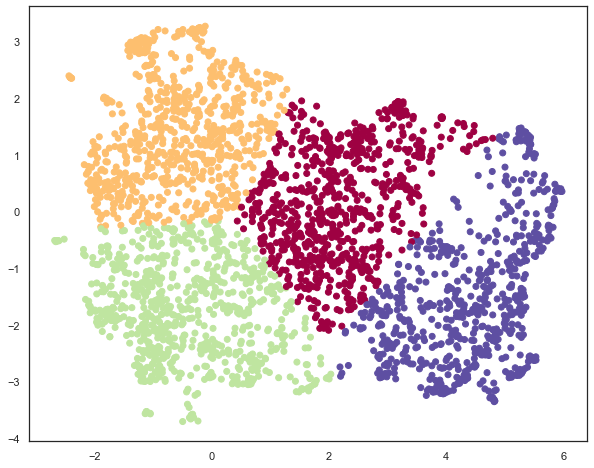

----------UMAP_bert1_hdbscan--------------------
{-1: 428, 0: 35, 1: 2447}


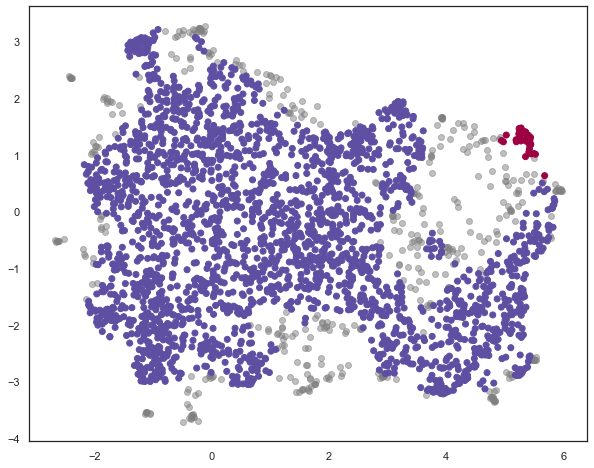

----------UMAP_bert1_norm--------------------
{0: 766, 1: 727, 2: 726, 3: 691}


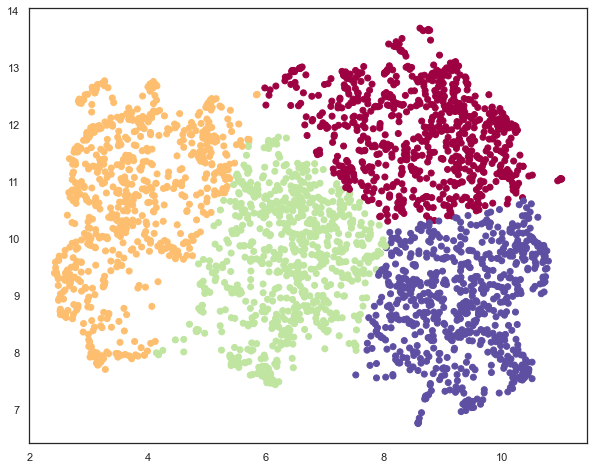

----------UMAP_bert1_norm_hdbscan--------------------
{-1: 667, 0: 1856, 1: 34, 2: 353}


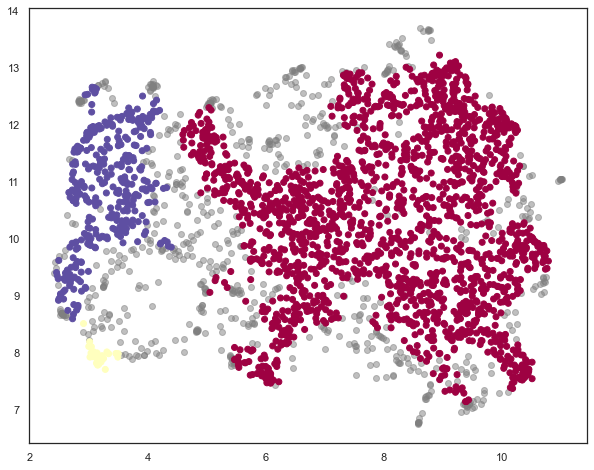

----------UMAP_bert2--------------------
{0: 575, 1: 1142, 2: 624, 3: 569}


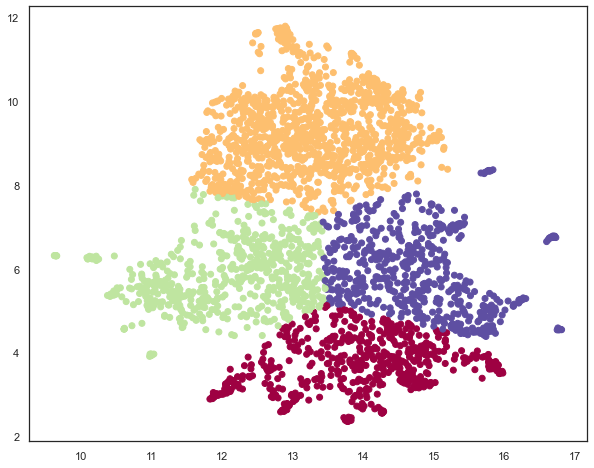

----------UMAP_bert2_hdbscan--------------------
{-1: 760, 0: 54, 1: 1007, 2: 41, 3: 34, 4: 30, 5: 140, 6: 24, 7: 820}


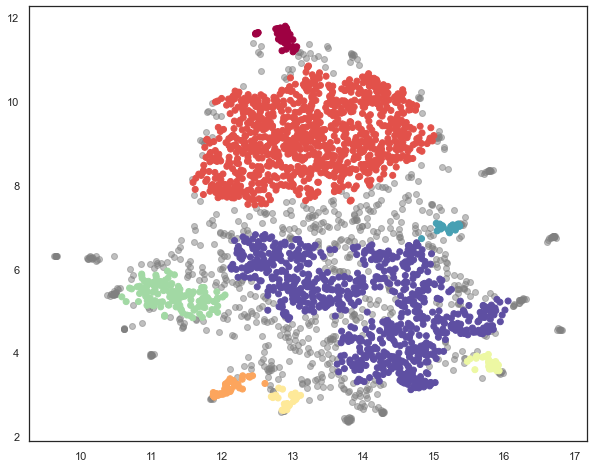

----------UMAP_bert2_norm--------------------
{0: 701, 1: 1131, 2: 472, 3: 606}


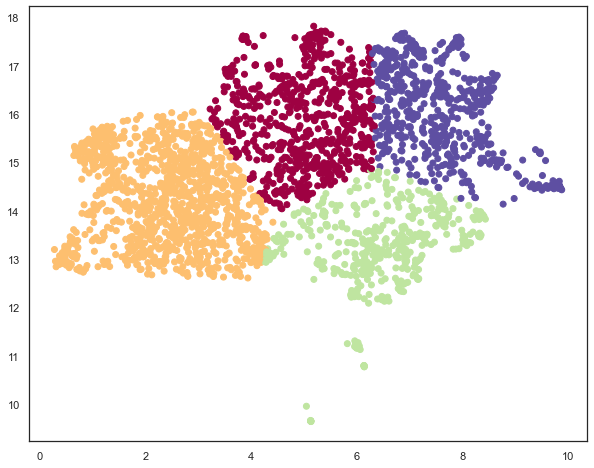

----------UMAP_bert2_norm_hdbscan--------------------
{-1: 394, 0: 41, 1: 260, 2: 70, 3: 2145}


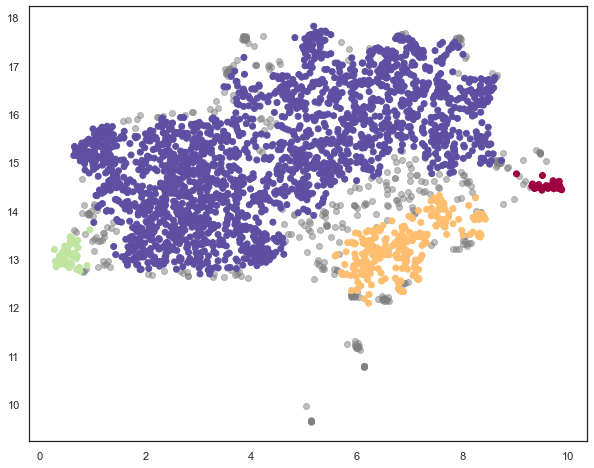

----------PCA_bert1--------------------
{0: 275, 1: 970, 2: 662, 3: 1003}


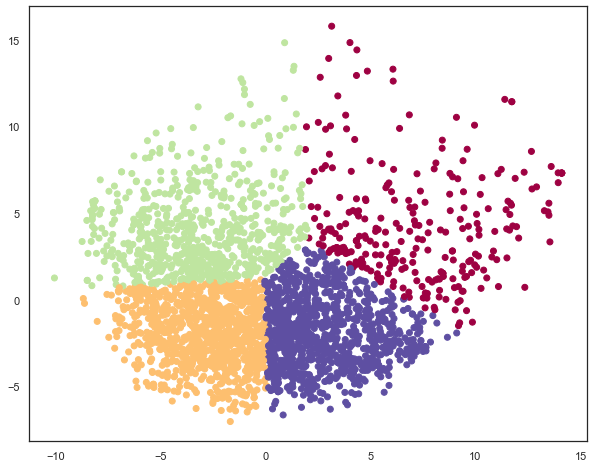

----------PCA_bert1_hdbscan--------------------
{-1: 1504, 0: 18, 1: 1388}


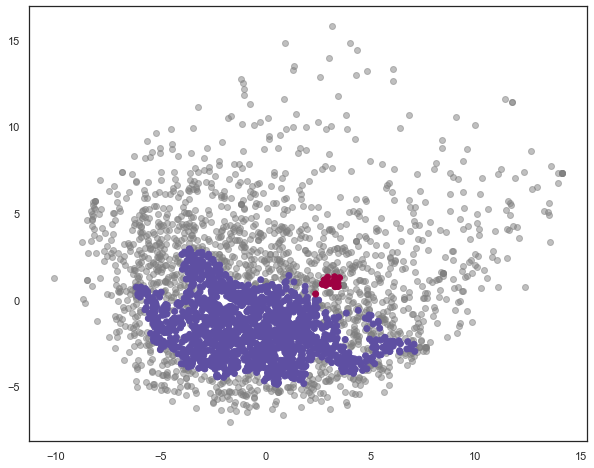

----------PCA_bert1_norm--------------------
{0: 300, 1: 695, 2: 952, 3: 963}


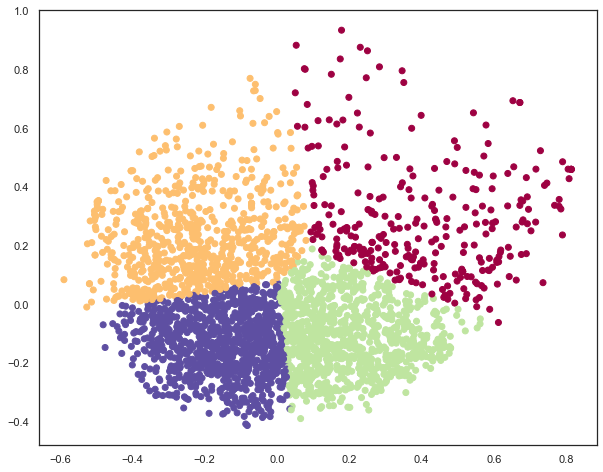

----------PCA_bert1_norm_hdbscan--------------------
{-1: 1458, 0: 15, 1: 1437}


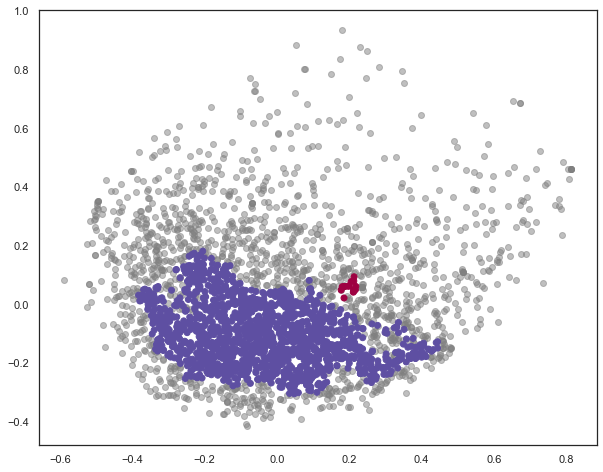

----------PCA_bert2--------------------
{0: 778, 1: 621, 2: 494, 3: 1017}


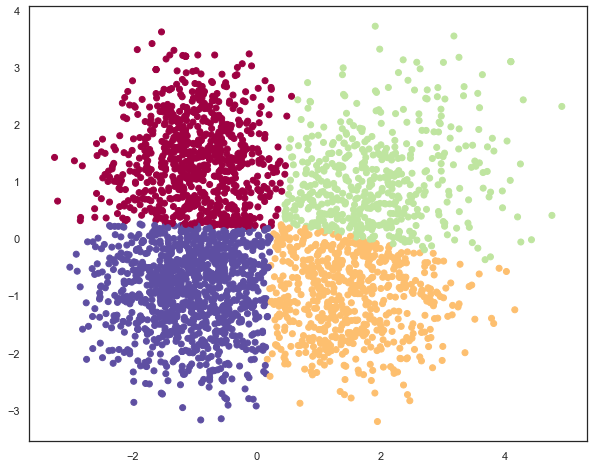

----------PCA_bert2_hdbscan--------------------
{-1: 1831, 0: 32, 1: 948, 2: 99}


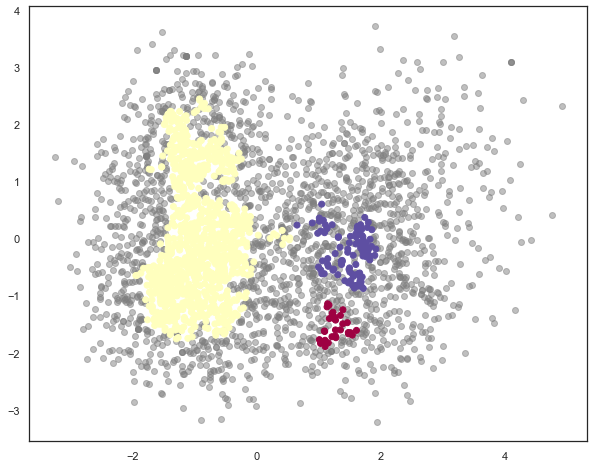

----------PCA_bert2_norm--------------------
{0: 807, 1: 983, 2: 618, 3: 502}


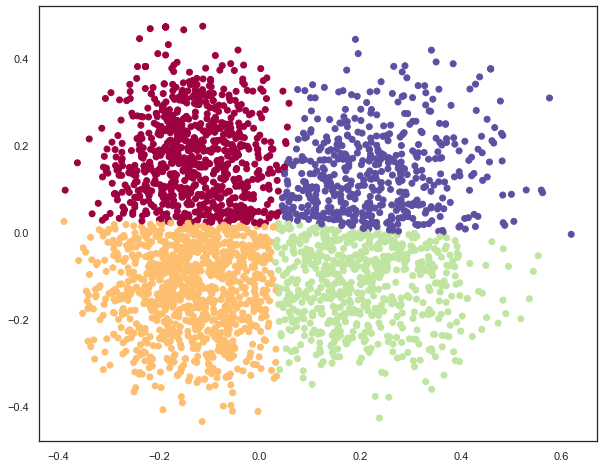

----------PCA_bert2_norm_hdbscan--------------------
{-1: 1036, 0: 1856, 1: 18}


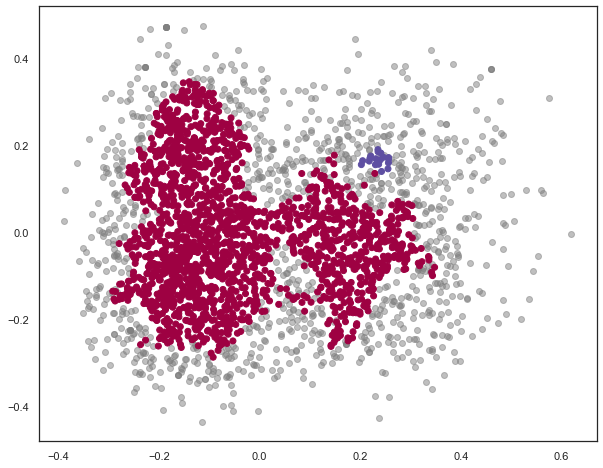

----------tSNE_bert1--------------------
{0: 722, 1: 701, 2: 744, 3: 743}


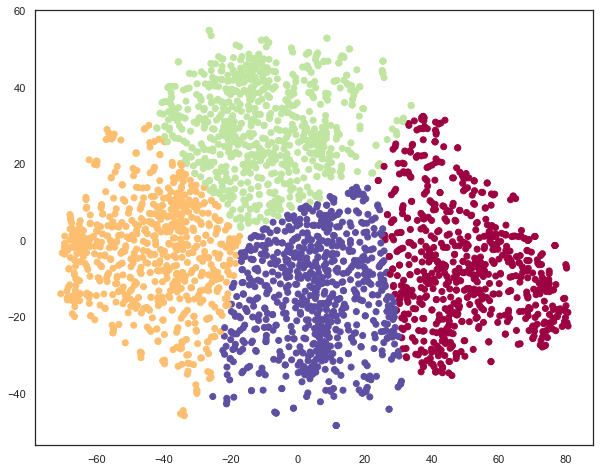

----------tSNE_bert1_hdbscan--------------------
{-1: 472, 0: 24, 1: 2414}


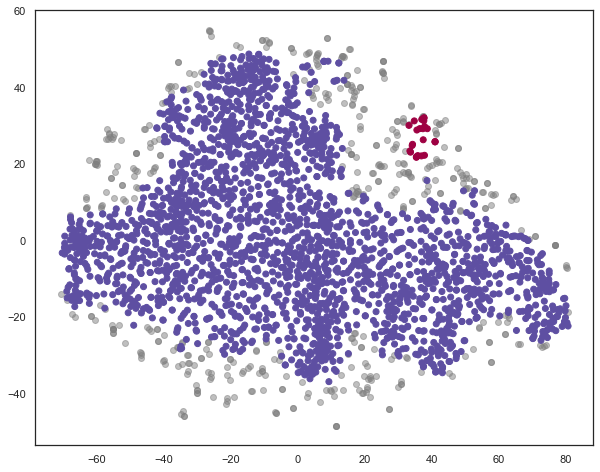

----------tSNE_bert1_norm--------------------
{0: 694, 1: 752, 2: 701, 3: 763}


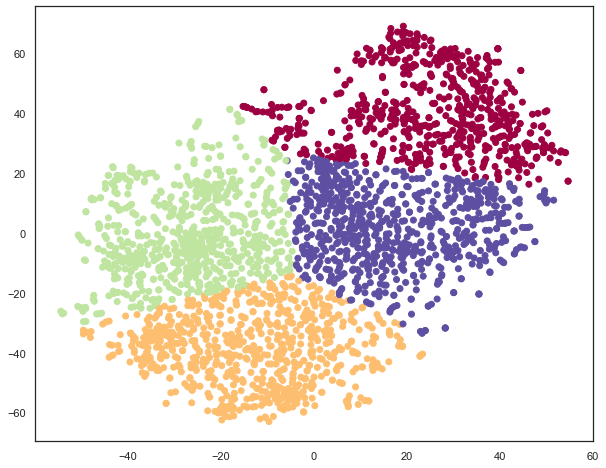

----------tSNE_bert1_norm_hdbscan--------------------
{-1: 623, 0: 28, 1: 15, 2: 2244}


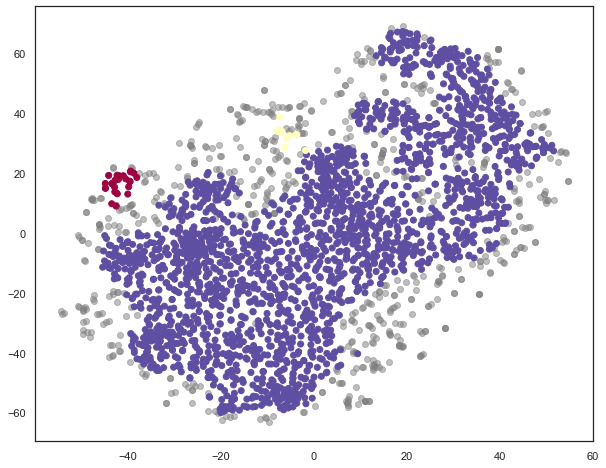

----------tSNE_bert2--------------------
{0: 610, 1: 687, 2: 1050, 3: 563}


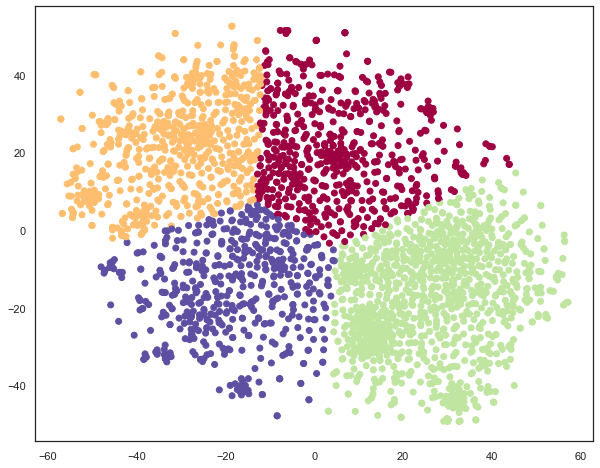

----------tSNE_bert2_hdbscan--------------------
{-1: 1231, 0: 31, 1: 49, 2: 41, 3: 736, 4: 77, 5: 745}


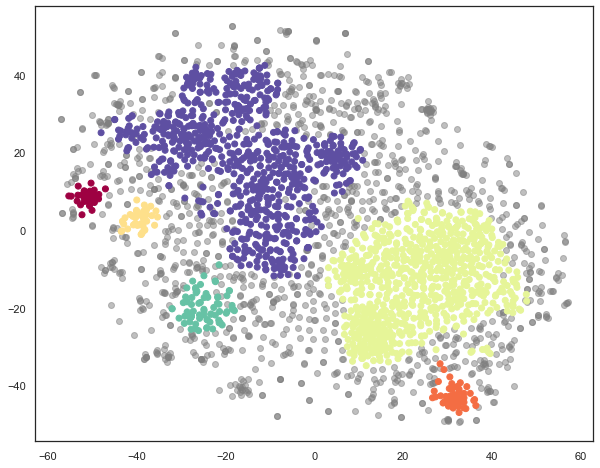

----------tSNE_bert2_norm--------------------
{0: 641, 1: 751, 2: 978, 3: 540}


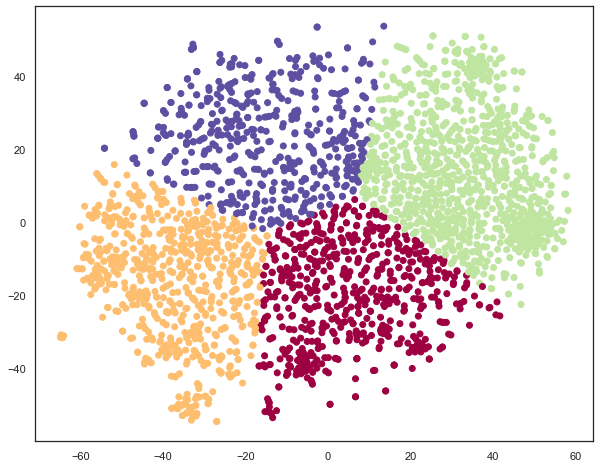

----------tSNE_bert2_norm_hdbscan--------------------
{-1: 628, 0: 35, 1: 76, 2: 2171}


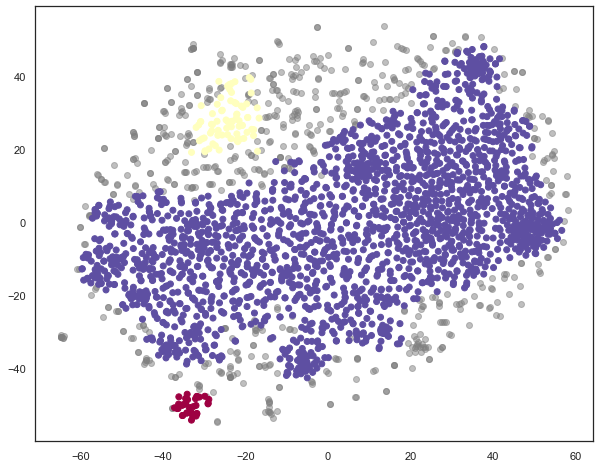

In [66]:
plot()

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidfmatrix(data, vectorizer):
    terms = vectorizer.fit_transform(data)
    return pd.DataFrame(terms.toarray(), columns = vectorizer.get_feature_names())

In [68]:
def cluster_words(clustering_result=clustering_result, top_n = 20, show_cross = False):
    for name, value in clustering_result.items():
        print(f"===================================={name}=============================================")
    
        #creatin new df in order to groupby same clusters
        cluster = value
        docs = pd.DataFrame(df_clean)
        docs["cluster"] = cluster

        labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"tweet": " ".join})

        try : 
            del labeled_docs_try
        except :
            pass
        labeled_docs_try =pd.DataFrame(df_clean)
        labeled_docs_try["labels"] = df.labels
        labeled_docs_try["cluster"] = docs.cluster
        labeled_docs_try.head(50)
        cross = pd.crosstab(labeled_docs_try.labels, labeled_docs_try.cluster)
        if show_cross:
            display(cross)
        else: pass
                
        tfidf_vec = TfidfVectorizer()
        tfidf_mat = tfidfmatrix(labeled_docs.tweet, tfidf_vec)
        
        global most_common
        most_common = pd.DataFrame({n: tfidf_mat.T[col].nlargest(top_n).index.tolist() 
                                for n, col in enumerate(tfidf_mat.T)}).T
        most_common.index = np.unique(cluster)
        display(most_common)

In [69]:
cluster_words(show_cross = True)

====================================UMAP_bert1=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              35  150   31   12
CHURN                        5   20    8    4
COVID19                     18   14   10    8
CUSTOMER_SERVICE_ISSUES     41   82   80   24
Customer Query              79   23   32   34
Customer Service Response   89   61   84  419
DELAY                      150  180  382    4
ESG                          1    4    0    1
GOOD REPUTATION             15   24   13   49
General                    303  152  125  133
Junk                         2    0    0    2
Language                     1    1    0    0

0               1           2                          3   \
0  bounce_back_loan  feeder_account     account                      hello   
1  bounce_back_loan  feeder_account    customer  worst_customer_experience   
2  bounce_back_loan        week_ago  still_wait                      apply   
3             thank           hello   full_name                hello_thank   

             4                 5               6      7        8           9   \
0         thank  business_account     credit_card   call    apply    customer   
1  hear_nothing             apply         nothing   call  account    business   
2           day              week  feeder_account  still  on_hold     account   
3        please        refer_link            send   help     team  link_below   

         10          11            12           13           14  \
0    please       email          help          pay  application   
1       say       worst           day         help        thank   
2      wait       email  good_morning  application         call   
3  let_know  click_link          call   sorry_hear       kindly   

               15                16                17     18                19  
0        business  loan_application  personal_account   need               say  
1            time           service             email  still              year  
2            sign              hour               say  thank              time  
3  name_post_code            number  click_link_below  check  thank_write_back

====================================UMAP_bert1_hdbscan=============================================


cluster                     -1   0    1
labels                                 
BAD REPUTATION              31   3  194
CHURN                        6   0   31
COVID19                     22   0   28
CUSTOMER_SERVICE_ISSUES     25   4  198
Customer Query              17   4  147
Customer Service Response  116   1  536
DELAY                       40   1  675
ESG                          0   0    6
GOOD REPUTATION             23   0   78
General                    145  20  548
Junk                         1   2    1
Language                     1   0    1

0             1                 2        3      4        5   \
-1             thank  good_morning  bounce_back_loan    hello   call     help   
 0          complain     complaint                dm     form   link  on_hold   
 1  bounce_back_loan         thank    feeder_account  account  apply    hello   

         6       7       8      9         10          11          12       13  \
-1  account  assist   covid   send       day  click_link  refer_link  service   
 0   please    send  anyone  hello    beread     curious   doesthank    mayis   
 1     call     day   email   help  customer      please  still_wait     wait   

        14        15           16         17           18          19  
-1  please  customer  hello_thank       make          see       happy  
 0   noand  somthing  sortedthank    dispute        ditto  electronic  
 1    week      time  application  full_name  hello_thank        need

====================================UMAP_bert1_norm=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              33   14   33  148
CHURN                        7    4    6   20
COVID19                     10   12   13   15
CUSTOMER_SERVICE_ISSUES     82   26   43   76
Customer Query              32   35   82   19
Customer Service Response   84  426   90   53
DELAY                      382    6  151  177
ESG                          0    1    1    4
GOOD REPUTATION             14   51   12   24
General                    120  147  292  154
Junk                         0    3    1    0
Language                     0    1    0    1

0               1            2                          3   \
0  bounce_back_loan        week_ago   still_wait                        day   
1             thank           hello  hello_thank                  full_name   
2  bounce_back_loan  feeder_account      account                      hello   
3  bounce_back_loan  feeder_account     customer  worst_customer_experience   

           4                 5               6             7         8   \
0       apply              week  feeder_account  good_morning   on_hold   
1  refer_link            please            send          help      team   
2       thank  business_account     credit_card          call  customer   
3       apply      hear_nothing         nothing          call   account   

           9         10          11      12                13           14  \
0       still   account        wait   email       application         call   
1  link_below  let_know  click_link    call        sorry_hear       kindly   
2       email     apply        help  please  loan_application  application   
3    business     worst         day     say              help        email   

               15     16       17                18        19  
0             say   sign     hour             thank      time  
1  name_post_code  check  message  click_link_below        dm  
2            need    say      pay  personal_account  business  
3         service   time    thank              year     still

====================================UMAP_bert1_norm_hdbscan=============================================


cluster                     -1    0   1    2
labels                                      
BAD REPUTATION              48  174   3    3
CHURN                        7   29   0    1
COVID19                     31   17   0    2
CUSTOMER_SERVICE_ISSUES     48  170   4    5
Customer Query              41  117   2    8
Customer Service Response  173  222   1  257
DELAY                       71  642   1    2
ESG                          0    5   0    1
GOOD REPUTATION             30   43   0   28
General                    214  433  21   45
Junk                         2    0   2    0
Language                     1    1   0    0

0                 1      2             3           4   \
-1             thank  bounce_back_loan  hello  good_morning        call   
 0  bounce_back_loan    feeder_account  apply       account  still_wait   
 1          complain         complaint     dm          form        link   
 2             thank         full_name  hello   hello_thank      please   

            5       6               7           8           9            10  \
-1        help  please         account       covid        send  hello_thank   
 0        week     day           email       thank        call     customer   
 1     on_hold    send          beread     curious   doesthank  marketmaker   
 2  refer_link    help  name_post_code  link_below  sorry_hear         team   

                    11                12        13           14        15  \
-1  phone_service_team        refer_link    assist   click_link  customer   
 0               hello  business_account      wait  application  week_ago   
 1               mayis             noand  somthing  sortedthank     ditto   
 2              kindly                dm      look        sorry      send   

                  16          17     18        19  
-1               day    let_know   need   service  
 0              time        help    pay      back  
 1                eh  electronic   gent  lawofbtc  
 2  click_link_below        call  check     write

====================================UMAP_bert2=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              29   88   62   49
CHURN                        4   21    8    4
COVID19                      1    1   42    6
CUSTOMER_SERVICE_ISSUES     15   51   34  127
Customer Query              26   43   65   34
Customer Service Response  354   16   48  235
DELAY                        6  639   42   29
ESG                          2    0    3    1
GOOD REPUTATION             26   16   27   32
General                    108  265  290   50
Junk                         3    0    1    0
Language                     0    0    1    1

0               1      2       3           4   \
0         full_name           thank  hello  please  refer_link   
1  bounce_back_loan  feeder_account  apply     day  still_wait   
2       credit_card         account  thank   covid       money   
3             hello            call  thank    team     on_hold   

                          5            6               7            8   \
0                 link_below  hello_thank  name_post_code   click_link   
1                      email         week            wait  application   
2                       help        hello             new         gold   
3  worst_customer_experience     customer          number    call_back   

        9                 10            11              12    13          14  \
0     send          let_know    sorry_hear          assist  help          dm   
1  account  business_account  hear_nothing           still   say  loan_apply   
2      pay            please       payment            make  sony    customer   
3   kindly              help   hello_thank  feeder_account  send      please   

                 15                16            17                  18  \
0  click_link_below           message  good_morning  phone_service_team   
1          business  loan_application          sign            customer   
2          transfer              need       support                time   
3           service            detail          time                hour   

         19  
0     email  
1  week_ago  
2        nt  
3       try

====================================UMAP_bert2_hdbscan=============================================


cluster                     -1   0    1   2   3   4    5   6    7
labels                                                           
BAD REPUTATION              72   2   75   0   1   0    4   0   74
CHURN                        5   0   21   0   0   1    0   0   10
COVID19                     29   0    1   0   0   0   15   1    4
CUSTOMER_SERVICE_ISSUES     58   0   44   1   0   0    1  17  106
Customer Query              37   1   38   0   0   0    0   2   90
Customer Service Response  199   2   16  36   2  28    1   0  369
DELAY                       84  11  591   0   0   1    1   0   28
ESG                          2   0    0   0   1   0    3   0    0
GOOD REPUTATION             47   1   13   0   8   0    7   1   24
General                    223  37  206   4  20   0  108   3  112
Junk                         2   0    0   0   2   0    0   0    0
Language                     2   0    0   0   0   0    0   0    0

0               1        2                          3   \
-1  bounce_back_loan           thank     send  worst_customer_experience   
 0  bounce_back_loan      lloydsbank   payout                        pay   
 1  bounce_back_loan  feeder_account    apply                      email   
 2      good_morning           query    happy                     assist   
 3             thank        generous       ok                       info   
 4        refer_link     hello_thank  request                 click_link   
 5             covid         support  fintech                  singapore   
 6           on_hold       call_back     hour                     minute   
 7         full_name     credit_card    thank                      hello   

            4                 5            6            7            8   \
-1       hello    feeder_account         call  hello_thank      account   
 0      anyone             today        lloyd    telegraph        apply   
 1  still_wait  business_account  application          day         wait   
 2          jp          everyone          day      morning        tweet   
 3        look     advertisement       beread   coordinate        donde   
 4      assist             order         call  information         need   
 5     digital         financial          gdp           uk        libra   
 6     give_up              call          cut        music         wait   
 7     account            please         send   link_below  hello_thank   

                9           10                11        12  \
-1          please  click_link       application       day   
 0            hear       think              well      good   
 1    hear_nothing        week  loan_application  business   
 2           great    tomorrow                zs      hope   
 3          hsbcar  idaireland   martindshanahan     mayis   
 4           phone     concern             hence     hello   
 5          mexico     package            werner  campaign   
 6            give        sort              hold    answer   
 7  name_post_code        call          customer        dm   

                    13          14                15        16       17  \
-1          still_wait        work              team     covid  receive   
 0               still        time            honest      luck   though   
 1             account  loan_apply  personal_account  week_ago     sign   
 2               thank        help                bl    sunday  evening   
 3      michaeljebelli    rthkenew              back      good       ah   
 4  phone_service_team     service            regard    nilesh    write   
 5               price         cir               oct     rugby     asia   
 6                 off         two          let_know     phone   second   
 7                team        help        sorry_hear   message    check   

          18             19  
-1  let_know           make  
 0      most             nt  
 1     still       customer  
 2   midweek          today  
 3   awesome  climatechange  
 4     thank        lalitha  
 5     seven          stock  
 6       try            yes  
 7    number          sorry

====================================UMAP_bert2_norm=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              95   86   36   11
CHURN                       15   19    2    1
COVID19                      7    2   41    0
CUSTOMER_SERVICE_ISSUES    148   54    9   16
Customer Query              88   42   11   27
Customer Service Response  142   28   14  469
DELAY                       71  612   28    5
ESG                          0    0    6    0
GOOD REPUTATION             34   20   33   14
General                     99  265  287   62
Junk                         0    0    4    0
Language                     0    1    1    0

0               1          2                 3       4   \
0       credit_card         account      thank           on_hold    call   
1  bounce_back_loan  feeder_account      apply               day   email   
2             thank           covid       gold  loan_application    sony   
3             thank           hello  full_name       hello_thank  please   

           5           6                          7               8   \
0       hello    customer  worst_customer_experience  feeder_account   
1  still_wait        week                application    hear_nothing   
2     support     nigeria                       help           money   
3  refer_link  link_below                       send        let_know   

               9           10                11          12       13  \
0             try      please              help        time      day   
1         account        wait  business_account    week_ago  nothing   
2            asia      market               new         see     amid   
3  name_post_code  sorry_hear              team  click_link     help   

         14         15       16          17            18                19  
0   service  call_back     wait        need          hour              make  
1      sign      still      say    business      customer  personal_account  
2  hongkong      china  fintech  loan_apply       economy            growth  
3    kindly     assist     call      detail  good_morning                dm

====================================UMAP_bert2_norm_hdbscan=============================================


cluster                     -1   0    1   2    3
labels                                          
BAD REPUTATION              38   0   14   9  167
CHURN                        7   0    0   1   29
COVID19                     17   0   25   0    8
CUSTOMER_SERVICE_ISSUES     34   1    5   0  187
Customer Query              12   0    0   3  153
Customer Service Response   57  39    7   2  548
DELAY                       42   0    6  16  652
ESG                          2   0    4   0    0
GOOD REPUTATION             34   0   21   1   45
General                    150   1  173  38  351
Junk                         0   0    4   0    0
Language                     1   0    1   0    0

0               1                          2   \
-1           on_hold  feeder_account  worst_customer_experience   
 0      good_morning           query                     assist   
 1             covid           thank                    support   
 2  bounce_back_loan         any_new                 lloydsbank   
 3  bounce_back_loan  feeder_account                      hello   

                  3           4            5                   6        7   \
-1  bounce_back_loan  click_link  hello_thank  phone_service_team     call   
 0             happy          jp      morning                  zs      day   
 1             money     company       during            campaign  fintech   
 2            anyone      really        apply   business_customer     turn   
 3             apply       thank        email             account     call   

           8           9           10           11          12          13  \
-1      thank  refer_link    business         sony        gold  still_wait   
 0      great        hope       today     tomorrow         nzt        help   
 1         uk         gdp         top    financial         say     economy   
 2      think      payout  still_wait        bored       chuff         tub   
 3  full_name        send      please  application  still_wait        help   

          14        15                16           17           18    19  
-1      hour      joke             covid       minute         year  help  
 0     tweet  everyone            friday       sunday      twitter  ayat  
 1      join     libra            mexico      package       werner  help  
 2      time     today          anything         come         hear  look  
 3  customer       day  business_account  hello_thank  credit_card  wait

====================================PCA_bert1=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              16   53  136   23
CHURN                        2   13   17    5
COVID19                      5   23   13    9
CUSTOMER_SERVICE_ISSUES     20   94   78   35
Customer Query              14   54   20   80
Customer Service Response   48   87   50  468
DELAY                        9  431  179   97
ESG                          0    1    4    1
GOOD REPUTATION             22   18   22   39
General                    135  195  142  241
Junk                         3    0    0    1
Language                     1    0    1    0

0               1                          2          3   \
0             thank           hello                     please       help   
1  bounce_back_loan  feeder_account                      email      apply   
2  bounce_back_loan  feeder_account  worst_customer_experience   customer   
3             thank           hello                hello_thank  full_name   

                 4             5           6                 7         8   \
0  bounce_back_loan          send    customer          let_know   on_hold   
1              week       account         day  business_account  week_ago   
2             apply  hear_nothing       worst           nothing  business   
3  bounce_back_loan        please  refer_link              send      team   

      9           10           11           12       13              14  \
0  still     welcome         need         safe     time            call   
1   call        wait   still_wait  application      say           still   
2    day  still_wait  credit_card         call  account             say   
3   help        call      account     let_know   number  name_post_code   

       15          16       17    18        19  
0   check         day       dm  link      make  
1    help    customer     time  sign  business  
2    time       money  service  year      week  
3  kindly  click_link    email  need    assist

====================================PCA_bert1_hdbscan=============================================


cluster                     -1   0    1
labels                                 
BAD REPUTATION             156   1   71
CHURN                       20   0   17
COVID19                     19   0   31
CUSTOMER_SERVICE_ISSUES    126   0  101
Customer Query              77   0   91
Customer Service Response  319   8  326
DELAY                      312   2  402
ESG                          5   0    1
GOOD REPUTATION             69   0   32
General                    395   7  311
Junk                         3   0    1
Language                     2   0    0

0               1               2           3   \
-1  bounce_back_loan           thank  feeder_account       hello   
 0        sorry_hear           hello       full_name  refer_link   
 1  bounce_back_loan  feeder_account         account       thank   

                4                 5       6           7       8     9   \
-1           apply           account    call       email  please  week   
 0  name_post_code  bounce_back_loan      dm  link_below  please    re   
 1           hello             email  please  still_wait   apply  wait   

          10   11     12           13           14        15       16  \
-1  customer  day   help         wait  application  business  on_hold   
 0   request  see  thank        apply       assist      call  concern   
 1      call  day   help  application  hello_thank      send     team   

            17                18           19  
-1  still_wait              time  hello_thank  
 0     control               day        error  
 1        week  business_account     customer

====================================PCA_bert1_norm=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              24  135   21   48
CHURN                        2   17    5   13
COVID19                      6   17    8   19
CUSTOMER_SERVICE_ISSUES     22   83   33   89
Customer Query              16   21   74   57
Customer Service Response   50   51  459   93
DELAY                       13  197   82  424
ESG                          0    4    1    1
GOOD REPUTATION             22   21   36   22
General                    141  148  228  196
Junk                         3    0    1    0
Language                     1    1    0    0

0               1                          2          3   \
0             thank           hello                       help     please   
1  bounce_back_loan  feeder_account  worst_customer_experience   customer   
2             thank           hello                hello_thank  full_name   
3  bounce_back_loan  feeder_account                      email      apply   

                 4             5            6                 7      8   \
0  bounce_back_loan       on_hold         send               cir  still   
1             apply  hear_nothing  credit_card               day   week   
2  bounce_back_loan        please   refer_link              send   help   
3           account          week          day  business_account   call   

         9     10          11           12          13       14          15  \
0  customer    dm    let_know   still_wait        time  welcome          be   
1   nothing  call    business      account  still_wait    still         say   
2      team  call     account     let_know      number   kindly  click_link   
3  week_ago  wait  still_wait  application         say     help       thank   

      16          17      18       19  
0   give        know    make     need  
1  money        time    year  service  
2   need  link_below  assist     look  
3  still    customer  please     time

====================================PCA_bert1_norm_hdbscan=============================================


cluster                     -1   0    1
labels                                 
BAD REPUTATION             152   0   76
CHURN                       20   0   17
COVID19                     18   0   32
CUSTOMER_SERVICE_ISSUES    124   0  103
Customer Query              69   0   99
Customer Service Response  307   8  338
DELAY                      298   1  417
ESG                          5   0    1
GOOD REPUTATION             67   0   34
General                    392   6  315
Junk                         3   0    1
Language                     2   0    0

0               1               2           3   \
-1  bounce_back_loan           thank  feeder_account       hello   
 0        sorry_hear       full_name           hello  refer_link   
 1  bounce_back_loan  feeder_account         account       thank   

                  4               5                 6        7           8   \
-1          customer           apply              help  account        call   
 0  bounce_back_loan  name_post_code  click_link_below  request         see   
 1             hello           email              help   please  still_wait   

         9       10     11         12       13           14           15  \
-1     time  please  email        day     week  application          say   
 0  history  assist   call  complaint  concern      control        great   
 1    apply    send   wait       call      day     customer  application   

       16        17           18          19  
-1  still  business         send  still_wait  
 0  hence   however  information        look  
 1    say     still  hello_thank        team

====================================PCA_bert2=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              79   35   41   73
CHURN                       11   10   11    5
COVID19                     48    0    1    1
CUSTOMER_SERVICE_ISSUES     36   43   12  136
Customer Query              43   24   21   80
Customer Service Response   87   21    5  540
DELAY                       32  383  233   68
ESG                          6    0    0    0
GOOD REPUTATION             39   28    7   27
General                    391   77  161   84
Junk                         4    0    0    0
Language                     2    0    0    0

0               1            2          3            4   \
0             thank           covid      account       help  credit_card   
1  bounce_back_loan  feeder_account        apply      email   still_wait   
2  bounce_back_loan  feeder_account   still_wait       week      account   
3             thank           hello  hello_thank  full_name       please   

            5                 6            7         8                 9   \
0         gold             money      support       new              sony   
1          day  business_account  application      wait      hear_nothing   
2        apply          business          day  customer  business_account   
3  credit_card              call   refer_link      send              team   

                 10                         11          12       13  \
0            please                     market         see     look   
1              call  worst_customer_experience    week_ago     week   
2  personal_account                        say         pay    still   
3              help                 sorry_hear  link_below  account   

          14       15        16        17            18        19  
0       time       be  business        nt         hello       say  
1  call_back  account     still       say          sign     phone  
2      money     take      loan      wait    loan_apply  week_ago  
3   customer   number    kindly  let_know  good_morning      need

====================================PCA_bert2_hdbscan=============================================


cluster                     -1   0    1   2
labels                                     
BAD REPUTATION             139   1   82   6
CHURN                       30   0    7   0
COVID19                     24   0   26   0
CUSTOMER_SERVICE_ISSUES    118   2  100   7
Customer Query              90   0   76   2
Customer Service Response  306   2  345   0
DELAY                      580  18   49  69
ESG                          3   0    3   0
GOOD REPUTATION             74   4   23   0
General                    462   5  231  15
Junk                         2   0    2   0
Language                     0   0    2   0

0                          1               2            3   \
-1  bounce_back_loan             feeder_account           thank        apply   
 0  bounce_back_loan  worst_customer_experience  feeder_account         call   
 1             thank                      hello       full_name  credit_card   
 2  bounce_back_loan             feeder_account           apply        email   

             4       5                 6                 7         8   \
-1        hello    call               day           account     email   
 0    call_back   email           receive        still_wait      wait   
 1  hello_thank  please           account              help  let_know   
 2   still_wait   still  personal_account  business_account       day   

            9         10            11          12               13       14  \
-1  still_wait  week_ago          week        wait           please     help   
 0       apply       day       nothing        sign  barclaysbizchat   person   
 1    customer      need          team  sorry_hear             send  on_hold   
 2     account      wait  hear_nothing     on_hold             week  any_new   

             15        16            17          18              19  
-1  application  customer     call_back         say            send  
 0  application      back  hear_nothing         she           still  
 1           dm      call    click_link  link_below  name_post_code  
 2     customer       say          sign     nothing         receive

====================================PCA_bert2_norm=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              80   69   38   41
CHURN                       11    5   10   11
COVID19                     48    1    0    1
CUSTOMER_SERVICE_ISSUES     40  131   44   12
Customer Query              41   82   22   23
Customer Service Response   95  532   21    5
DELAY                       37   64  377  238
ESG                          6    0    0    0
GOOD REPUTATION             44   23   26    8
General                    399   73   79  162
Junk                         4    0    0    0
Language                     2    0    0    0

0               1            2          3           4   \
0             thank           covid      account       help       money   
1             thank           hello  hello_thank  full_name      please   
2  bounce_back_loan  feeder_account        apply      email  still_wait   
3  bounce_back_loan  feeder_account         week    account       apply   

         5                 6            7            8             9      10  \
0      gold               new      support       please   credit_card   sony   
1      call        refer_link         send  credit_card          help   team   
2       day  business_account  application         wait  hear_nothing   call   
3  business        still_wait          day          say      customer  still   

                          11                12       13        14         15  \
0                       look              time       nt       see     market   
1                 sorry_hear        link_below  account  customer     number   
2  worst_customer_experience           account     week  week_ago  call_back   
3                      money  business_account     loan      take        pay   

       16        17            18        19  
0      be  business          make  customer  
1  kindly  let_know  good_morning      need  
2     say     still          sign     phone  
3    wait      sign         today      back

====================================PCA_bert2_norm_hdbscan=============================================


cluster                     -1    0   1
labels                                 
BAD REPUTATION              56  169   3
CHURN                       14   22   1
COVID19                     17   33   0
CUSTOMER_SERVICE_ISSUES     62  165   0
Customer Query              38  129   1
Customer Service Response  203  450   0
DELAY                      338  368  10
ESG                          3    3   0
GOOD REPUTATION             31   69   1
General                    270  441   2
Junk                         1    3   0
Language                     0    2   0

0                 1        2        3     4      5       6   \
-1  bounce_back_loan    feeder_account    thank    hello  call  apply     day   
 0             thank  bounce_back_loan    hello  account  help    day  please   
 1  bounce_back_loan          hulstone  account    apply   say    see   think   

          7                 8            9           10          11  \
-1     email  business_account         help  still_wait        wait   
 0  customer    feeder_account         call       email  still_wait   
 1       try            anyone  application    approval     balance   

           12         13        14           15       16      17           18  \
-1  call_back   customer  week_ago     business  account  number         time   
 0       time  full_name      wait  credit_card    apply    need  hello_thank   
 1        doc       hard      open       please  qstweet  really    santander   

        19  
-1  please  
 0    team  
 1    tell

====================================tSNE_bert1=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION               9  148   27   44
CHURN                        2   20    7    8
COVID19                     16   19    3   12
CUSTOMER_SERVICE_ISSUES     19   82   76   50
Customer Query              34   18   30   86
Customer Service Response  386   53   75  139
DELAY                        8  185  375  148
ESG                          1    4    0    1
GOOD REPUTATION             48   23   12   18
General                    192  148  137  236
Junk                         4    0    0    0
Language                     1    1    0    0

0               1               2   \
0             thank       full_name           hello   
1  bounce_back_loan  feeder_account        customer   
2  bounce_back_loan        week_ago      still_wait   
3  bounce_back_loan         account  feeder_account   

                          3       4               5       6   \
0                hello_thank  please      refer_link    send   
1  worst_customer_experience   apply         nothing    call   
2                        day   apply  feeder_account    week   
3                      thank   hello           email  please   

                 7         8        9               10        11           12  \
0        link_below      help     team  name_post_code      call       kindly   
1      hear_nothing  business    worst             day   account          say   
2           account     still  on_hold            wait     email  application   
3  business_account     apply     help     credit_card  customer          pay   

             13      14        15                16           17  \
0    sorry_hear  number    detail  click_link_below        check   
1          help   still      time           service         year   
2  good_morning    call       say              sign         hour   
3          call    send  business              need  application   

                 18                19  
0  thank_write_back                dm  
1              wait             money  
2  business_account              back  
3        click_link  loan_application

====================================tSNE_bert1_hdbscan=============================================


cluster                     -1   0    1
labels                                 
BAD REPUTATION              37   1  190
CHURN                        5   0   32
COVID19                     26   1   23
CUSTOMER_SERVICE_ISSUES     36   0  191
Customer Query              19   1  148
Customer Service Response   98   0  555
DELAY                       46   0  670
ESG                          3   0    3
GOOD REPUTATION             24   0   77
General                    177  21  515
Junk                         1   0    3
Language                     0   0    2

0             1                 2      3        4   \
-1             thank  good_morning  bounce_back_loan   help  any_new   
 0              asia       capital       doubledigit    see    asset   
 1  bounce_back_loan         thank    feeder_account  hello    apply   

           5       6       7        8            9         10        11    12  \
-1      hello   covid     new  account          day    please  customer  time   
 0  financial     gdp  growth      say       wealth  deutsche     expat  land   
 1    account  please     day    email  hello_thank      help  customer  call   

            13       14     15           16     17         18    19  
-1       today  support  happy         week  money    on_hold  back  
 0         asa     bnpp   bofa          btg  fator       hsba   iif  
 1  still_wait     send   wait  application  still  full_name  week

====================================tSNE_bert1_norm=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              15  151   23   39
CHURN                        4   20    7    6
COVID19                     14   24    5    7
CUSTOMER_SERVICE_ISSUES     17   86   70   54
Customer Query              24   21   31   92
Customer Service Response  339   39  100  175
DELAY                       11  226  326  153
ESG                          1    4    1    0
GOOD REPUTATION             48   26   12   15
General                    214  154  124  221
Junk                         4    0    0    0
Language                     1    1    0    0

0               1               2             3   \
0             thank           hello      refer_link     full_name   
1  bounce_back_loan  feeder_account           apply  hear_nothing   
2  bounce_back_loan        week_ago      still_wait          week   
3  bounce_back_loan           thank  feeder_account         hello   

            4        5                          6                 7        8   \
0  hello_thank   please                       send              team     help   
1     customer  nothing  worst_customer_experience              call      day   
2        apply      day             feeder_account             still  account   
3      account    email                     please  business_account     call   

           9               10                11      12     13  \
0  link_below  name_post_code  click_link_below  kindly   call   
1     account           email          business     say  worst   
2     on_hold            wait      good_morning   thank   call   
3    customer            help       application   apply   send   

                 14       15    16          17                  18      19  
0  thank_write_back    check    dm  sorry_hear  phone_service_team  detail  
1              time    still  wait        help                 pay   money  
2             email   please  sign         say               today    time  
3       credit_card  receive   pay    let_know            business    need

====================================tSNE_bert1_norm_hdbscan=============================================


cluster                     -1   0   1    2
labels                                     
BAD REPUTATION              51   0   0  177
CHURN                        6   0   0   31
COVID19                     31   0   0   19
CUSTOMER_SERVICE_ISSUES     47   2   0  178
Customer Query              42   3   1  122
Customer Service Response  141  18   0  494
DELAY                       61   2   0  653
ESG                          2   0   0    4
GOOD REPUTATION             15   1   0   85
General                    225   1  14  473
Junk                         1   0   0    3
Language                     0   0   0    2

0               1                 2       3       4   \
-1             thank           hello  bounce_back_loan    help  please   
 0      good_morning           thank            assist   query   happy   
 1       doubledigit            asia             asset  growth  wealth   
 2  bounce_back_loan  feeder_account             thank   hello   apply   

          5        6      7           8                 9        10       11  \
-1  customer    covid    day          nt              call     time  account   
 0        jp      day   help      please           midweek  account      new   
 1       see  deficit    gdp      around             bajaj  digital  finance   
 2  customer   please  email  still_wait  business_account      day     wait   

                  12           13           14           15         16  \
-1              need  credit_card          try        still        new   
 0  bounce_back_loan         make         call         jeff   everyone   
 1              grow        india         rise  beneficiary  borrowing   
 2              week      account  hello_thank          say       call   

                 17         18        19  
-1              say       team     today  
 0           friday  full_name     great  
 1  businessinsider      class    dankie  
 2             help       send  business

====================================tSNE_bert2=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              86   25   72   45
CHURN                       10    1   18    8
COVID19                      6    0    1   43
CUSTOMER_SERVICE_ISSUES    121   21   46   39
Customer Query              53   29   41   45
Customer Service Response  122  474   16   41
DELAY                       78    4  599   35
ESG                          0    3    0    3
GOOD REPUTATION             34   33   13   21
General                     98   94  242  279
Junk                         0    2    0    2
Language                     1    0    0    1

0               1         2            3       4   \
0       credit_card            call  customer        hello   thank   
1             thank       full_name     hello  hello_thank  please   
2  bounce_back_loan  feeder_account     apply          day   email   
3           account           thank   on_hold        covid     new   

                          5                 6                 7   \
0  worst_customer_experience  bounce_back_loan    feeder_account   
1                       send        link_below        refer_link   
2                       week        still_wait  loan_application   
3                      money              gold             hello   

                 8        9            10          11          12        13  \
0        still_wait  account         wait         day        team      time   
1    name_post_code     help   click_link  sorry_hear        team  let_know   
2  business_account     wait  application    week_ago  loan_apply   account   
3              sony     help         make     support      market      open   

        14       15        16      17            18                19  
0  service      try      help  please     call_back               say  
1   kindly     call    assist      dm       message            detail  
2    still     sign  business     say  hear_nothing  personal_account  
3     fund  payment    please    need       nigeria          transfer

====================================tSNE_bert2_hdbscan=============================================


cluster                     -1   0   1   2    3   4    5
labels                                                  
BAD REPUTATION             129   1   3   0   49   2   44
CHURN                       15   0   0   0   14   0    8
COVID19                     33   0   0   0    1  10    6
CUSTOMER_SERVICE_ISSUES    105   0   0   1   30   0   91
Customer Query              67   0   2   0   26   0   73
Customer Service Response  221   2   2  37   11   0  380
DELAY                      214   0   8   0  457   1   36
ESG                          4   1   0   0    0   0    1
GOOD REPUTATION             64   9   1   0    6   1   20
General                    371  18  33   3  141  63   84
Junk                         4   0   0   0    0   0    0
Language                     2   0   0   0    0   0    0

0               1            2                  3   \
-1  bounce_back_loan           thank     customer              hello   
 0             thank        generous           ok             aboard   
 1  bounce_back_loan           apply        leant  business_customer   
 2      good_morning           query        happy             assist   
 3  bounce_back_loan  feeder_account        apply              email   
 4             covid            asia       growth              asset   
 5         full_name           hello  credit_card        hello_thank   

                  4           5                 6           7            8   \
-1             email     on_hold               day        send      account   
 0     advertisement         ash            beread  brumleader   coordinate   
 1         telegraph        come             still        well        least   
 2                jp        help           morning    everyone          day   
 3  business_account  still_wait  loan_application        week  application   
 4       doubledigit         gdp            wealth      werner    financial   
 5             thank     account            please        send         call   

            9           10                         11              12  \
-1  still_wait        call  worst_customer_experience  feeder_account   
 0  coventrycc     grocery                 idaireland  inthistogether   
 1        hear      honest                      issue            luck   
 2       today        hope                      great           tweet   
 3        wait     account                 loan_apply    hear_nothing   
 4     fintech         cir                        see          global   
 5  refer_link  link_below             name_post_code          number   

                  13             14               15              16  \
-1              make           help             time              be   
 0              kris  libraryofbham  martindshanahan  michaeljebelli   
 1            though           turn              yes        anything   
 2          thursday             zs            thank            ayat   
 3  personal_account       week_ago              day        business   
 4           economy          libra          package            bond   
 5        sorry_hear         kindly             team           check   

             17          18        19  
-1       please        work      week  
 0  mindcharity  nhsbsolccg  rthkenew  
 1          ceo        most      same  
 2      midweek       nanis        ai  
 3        still        sign  customer  
 4        spark     include    market  
 5         help     request    detail

====================================tSNE_bert2_norm=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              73   18   68   69
CHURN                       13    1   18    5
COVID19                     10   12    2   26
CUSTOMER_SERVICE_ISSUES    140   17   44   26
Customer Query              74   27   38   29
Customer Service Response   86  511   12   44
DELAY                       99    3  548   66
ESG                          0    2    0    4
GOOD REPUTATION             33   38   15   15
General                    111  119  231  252
Junk                         0    2    0    2
Language                     0    0    0    2

0               1           2            3       4   \
0       credit_card         on_hold     account         call   thank   
1             thank       full_name       hello  hello_thank  please   
2  bounce_back_loan  feeder_account       apply   still_wait   email   
3  loan_application           covid  loan_apply        thank    help   

                 5         6                          7           8   \
0  bounce_back_loan  customer  worst_customer_experience         day   
1              send      team                 refer_link  link_below   
2               day      week           business_account        wait   
3  bounce_back_loan      sony                    account        loan   

               9               10          11          12        13  \
0           hello  feeder_account      please        hour     phone   
1  name_post_code            help  sorry_hear  click_link      call   
2         account     application    week_ago       still       say   
3           money          please         say       still  business   

            14            15            16                17  \
0  application          make       service              time   
1     let_know        kindly  good_morning            detail   
2     customer  hear_nothing      business  personal_account   
3           nt          back         hello           nigeria   

                  18       19  
0  business_customer      try  
1             assist   number  
2            nothing  on_hold  
3               need      new

====================================tSNE_bert2_norm_hdbscan=============================================


cluster                     -1   0   1    2
labels                                     
BAD REPUTATION              73   0   5  150
CHURN                        7   0   1   29
COVID19                     24   0  11   15
CUSTOMER_SERVICE_ISSUES     58   1   0  168
Customer Query              32   0   0  136
Customer Service Response   65  34   1  553
DELAY                       73   0   0  643
ESG                          2   0   3    1
GOOD REPUTATION             22   0   2   77
General                    267   0  51  395
Junk                         2   0   2    0
Language                     2   0   0    0

0               1        2        3         4        5   \
-1  bounce_back_loan         on_hold    thank  any_new  customer    covid   
 0      good_morning           query   assist    happy        jp      day   
 1             covid             gdp  economy    money      jail  vietnam   
 2  bounce_back_loan  feeder_account    hello    apply     thank  account   

         6      7               8           9        10        11  \
-1  account     nt             say          be   please     hello   
 0  morning  today        everyone       tweet  evening  thursday   
 1   global    say  birminghamlgbt        bond     bvsc    fossil   
 2    email   call        customer  still_wait      day      send   

             12      13           14         15      16         17  \
-1        money   still         sony       card    hour       look   
 0     tomorrow    hope           zs         bl    help       ayat   
 1         fuel    join       market    support  during  financial   
 2  application  please  hello_thank  full_name    wait       help   

            18                19  
-1  click_link               new  
 0     midweek             nanis  
 1          he          currency  
 2        week  business_account